In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# import required packages
import sys
sys.path.append('../../')

import numpy as np
import os
import math

import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

from scipy.stats import rankdata
from scipy.stats import wilcoxon

from src.utils.data_functions import load_data

from sklearn.datasets import fetch_openml

# Data Set Overview

In [2]:
data_sets = pd.read_csv('../../data_set_ids.csv')
data_set_openml = {}
data_set_ids = {}
n_instances_list = []
for i, d in data_sets.iterrows():
    X, y = load_data(data_set_name=d['name'])
    n_instances_list.append(len(X))
    if 'reports' in d['name']:
        data_set_openml[d['name']] = d['name']
        data_set_ids[d['name']] =  '-'
    else:
        data = fetch_openml(data_id=d['id'])
        data_set_openml[d['name']] = '{} (v{})'.format(data.details['name'], data.details['version'])
        data_set_ids[d['name']] = int(data.details['id'])
    n_features = np.size(X, axis=1)
    classes, class_distribution = np.unique(y, return_counts=True)
    print(r'{}: n_features = {}, n_samples = {}, class distribution = {}'.format(d['name'], n_features, len(X), class_distribution))
sorting = np.argsort(n_instances_list)
n_instances_list = np.array(n_instances_list)

breast-cancer-wisconsin: n_features = 30, n_samples = 569, class distribution = [357 212]
blood-transfusion: n_features = 4, n_samples = 748, class distribution = [570 178]
pima-indians-diabetes: n_features = 8, n_samples = 768, class distribution = [500 268]
ionosphere: n_features = 34, n_samples = 351, class distribution = [126 225]
sonar: n_features = 60, n_samples = 208, class distribution = [111  97]
biodegradation: n_features = 41, n_samples = 1055, class distribution = [699 356]
vehicle: n_features = 18, n_samples = 846, class distribution = [218 212 217 199]
ecoli: n_features = 7, n_samples = 336, class distribution = [143  77   2   2  35  20   5  52]
glass: n_features = 9, n_samples = 214, class distribution = [70 76 13 29  9 17]
vertebra-column: n_features = 6, n_samples = 310, class distribution = [ 60 100 150]
user-knowledge: n_features = 5, n_samples = 403, class distribution = [102 129 122  24  26]
kc2: n_features = 21, n_samples = 522, class distribution = [415 107]
park

# Evaluation Plots


## Parameters
Below, you can define the parameters of the executed experiments. Switching between the kernels rbf, categorical, and cosine is necessary to reproduce all results of the article.
You need to adjust the parameter `n_repeats` according to the number of experiments you ran a each strategy on a data set.

In [3]:
# define parameters
budget = 200 # number of annotation acquisitions
test_ratio = 0.4 # fraction of test samples
kernel = 'rbf' # options: 'rbf', 'categorical', 'cosine'
bandwidth = 'mean' # procedure for determining bandwidth
n_repeats = 1 # number of runs per experiment

# path where you stored the results
abs_path = '../../results' # default path

## Learning Curves

iris


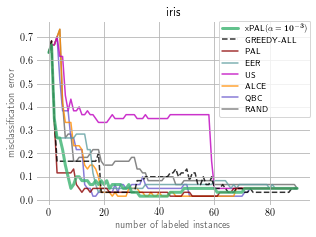

corral
wine
parkinsons
prnn-craps
sonar
seeds
seismic-bumps
glass
bankruptcy
vertebra-column
ecoli
ionosphere
user-knowledge
chscase-vine
kc2
monks
breast-cancer-wisconsin
balance-scale
reports-mozilla
blood-transfusion
pima-indians-diabetes
vehicle
tic
reports-compendium
biodegradation
banknote
car
steel-plates-fault


In [4]:
# plot setup
fontsize = 20

data_sets = pd.read_csv('../../data_set_ids.csv', index_col='id')
data_set_names = data_set_names = data_sets.name.values[sorting]
  

# setup for query strategies
query_strategy_dict = {
                        'random': ['dimgrey', '-', 'RAND'],
                        'qbc': ['slateblue', '-', 'QBC'],
                        'alce': ['darkorange', '-', 'ALCE'],
                        'lc': ['m', '-', 'US'],
                        'zero-one-loss': ['cadetblue', '-', 'EER'],
                        'pal-1': ['darkred', '-', 'PAL'],
                        'optimal': ['k', '--', 'GREEDY-ALL'],
                        'xpal-1': ['g', ':', r'xPAL$(\mathbf{\alpha}=\mathbf{1})$'],
                        'xpal-0.001': ['mediumseagreen', '-', r'xPAL$(\mathbf{\alpha}=\mathbf{10^{-3}})$'],
                      }


# setup for data sets
for d in data_set_names:
    print(d)
    X, y = load_data(data_set_name=d)
    n_samples = len(X)
    n_train_samples = math.floor(n_samples * (1 - test_ratio))
    n_features = np.size(X, axis=1)
    classes, class_distribution = np.unique(y, return_counts=True)
    is_available = False

    for q_idx, q in enumerate(reversed(list(query_strategy_dict.keys()))):
        csv_name = '{}_{}_{}_{}_{}_{}'.format(d, q, test_ratio, kernel, bandwidth, budget)
        performances = []
        for file in os.listdir(abs_path):
            if csv_name in file:
                path = os.path.join(abs_path, file)
                df = pd.read_csv(path)
                if not is_available:
                    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.4))
                    plt.title('{}'.format(d))
                    is_available = True
                performances.append(df['test-error'])
        if len(performances):
            mean_perfs = np.mean(performances, axis=0)
            lw = 3 if 'xpal-0.001' == q else 1.5
            alpha = 0.8
            ax.plot(mean_perfs, color=query_strategy_dict[q][0], label=query_strategy_dict[q][2], ls=query_strategy_dict[q][1], lw=lw, alpha=alpha, zorder=-q_idx)

    if is_available:  
        ax.set_xlabel(r'number of labeled instances')
        ax.set_ylabel(r'misclassification error')
        leg = fig.legend(loc='upper right', bbox_to_anchor=(0.97, 0.9), fontsize=8)
        fig.tight_layout()
        fig.savefig("../../images/learning_curves_{}_{}.pdf".format(d, kernel), bbox_inches='tight')
        plt.show()

## Ranks of Area Under Learning Curve

To create the ranking statistics, we need at __n_repeats__ runs for each strategy and each data set.

Execute cell to compute mean ranks and test for significance.

In [5]:
# data sets
data_sets = pd.read_csv('../../data_set_ids.csv', index_col='id')
data_set_names = data_sets.name.values[sorting]
data_set_names_openml = [data_set_openml[d] for d in data_set_names]


# setup for query strategies
query_strategy_dict = {
                       'xpal-0.001': r'xPAL$(\mathbf{\alpha}=\mathbf{10^{-3}})$',
                       'pal-1': 'PAL',
                       'lc': 'US',
                       'alce': 'ALCE',
                       'qbc': 'QBC',
                       'zero-one-loss': 'EER',
                       'random': 'RAND',
                      }
n_strategies = len(query_strategy_dict)

# compute areas under learning curves and corresponding rank matrices
auc_ranks_matrix = np.zeros((n_strategies, len(data_set_names)))
performances = np.zeros((len(data_set_names), n_strategies, n_repeats))
is_available = np.zeros(len(data_set_names), dtype=bool)
for d_idx, d in enumerate(data_set_names):
    for q_idx, q in enumerate(query_strategy_dict.keys()):
        seed_list = []
        performance_list = []
        csv_name = '{}_{}_{}_{}_{}_{}'.format(d, q, test_ratio, kernel, bandwidth, budget)
        for file in os.listdir(abs_path):
            if csv_name in file:
                is_available[d_idx] = True
                path = os.path.join(abs_path, file)
                df = pd.read_csv(path)
                seed = int(file.split('.')[-2].split('_')[-1])
                seed_list.append(seed)
                performance_list.append(np.mean(df['test-error']))
        if len(seed_list):
            sort_indices = np.array(np.argsort(seed_list), dtype=int)
            performances[d_idx, q_idx, :] = np.array(performance_list)[sort_indices]
    auc_ranks_matrix[:, d_idx] = np.mean(np.array([rankdata(performances[d_idx, :, r]) for r in range(n_repeats)]), axis=0)
performances = performances[is_available]
auc_ranks_matrix = auc_ranks_matrix[:, is_available]

## Table of Mean AULC Values and Standard Deviations

Execute cell to obtain LaTeX table of mean AULC including standard deviations and information about significance.

In [6]:
strategy_list = list(query_strategy_dict.keys())
df = pd.DataFrame(index=np.array(data_set_names_openml)[is_available], columns=strategy_list)
index_best = performances.mean(axis=-1).argmin(axis=1)
test_results = np.zeros((len(data_set_names[is_available]), len(strategy_list)))
cmp_idx = strategy_list.index('xpal-0.001')
i = 0
for d_idx, d in enumerate(np.array(data_set_names_openml)[is_available]):
    print(d)
    for q_idx, q in enumerate(strategy_list):
        teststr = ''
        if q_idx != cmp_idx:
            test = wilcoxon(performances[d_idx, cmp_idx], performances[d_idx, q_idx], alternative='less')
            if test.pvalue < 0.001:
                test_results[d_idx, q_idx] = 3
                i += 1
                teststr = '***'
            elif test.pvalue < 0.01:
                test_results[d_idx, q_idx] = 2
                teststr = '**'
            elif test.pvalue < 0.05:
                test_results[d_idx, q_idx] = 1
                teststr = '*'
            else:
                test = wilcoxon(performances[d_idx, cmp_idx], performances[d_idx, q_idx], alternative='greater')
                if test.pvalue < 0.001:
                    test_results[d_idx, q_idx] = -3
                    teststr = '?(?dagger?dagger?dagger?)'
                elif test.pvalue < 0.01:
                    test_results[d_idx, q_idx] = -2
                    teststr = '?(?dagger?dagger?)'
                elif test.pvalue < 0.05:
                    test_results[d_idx, q_idx] = -1
                    teststr = '?(?dagger?)'
            test = wilcoxon(performances[d_idx, cmp_idx], performances[d_idx, q_idx], alternative='less')
        if index_best[d_idx] == q_idx:
            df.loc[d, q] = r'\textbf{'+'{:1.3f}'.format(performances[d_idx, q_idx].mean()) + r'}' + '(?tpm{:1.3f}){}'.format(performances[d_idx, q_idx].std(), teststr)
        else:
            df.loc[d, q] = '{:1.3f} (?tpm{:1.3f}){}'.format(performances[d_idx, q_idx].mean(), performances[d_idx, q_idx].std(), teststr)
print(df.to_latex(float_format='%.2f').replace('?','\\').replace('0.','.').replace(r'\textbackslash','').replace(r'\{','{').replace(r'\}','}').replace(r'textbf',r'\textbf').replace('...', 'er'))

iris (v1)
\begin{tabular}{llllllll}
\toprule
{} &         xpal-.001 &                      pal-1 &                 lc &               alce &                qbc &      zero-one-loss &             random \\
\midrule
iris (v1) &  .073 (\tpm.000) &   \textbf{.061}(\tpm.000) &  .273 (\tpm.000) &  .097 (\tpm.000) &  .096 (\tpm.000) &  .107 (\tpm.000) &  .146 (\tpm.000) \\
\bottomrule
\end{tabular}



/home/marek/miniconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


## Colored Mean Ranking Plots

Execute cell to create colored plots of ranking statistics.

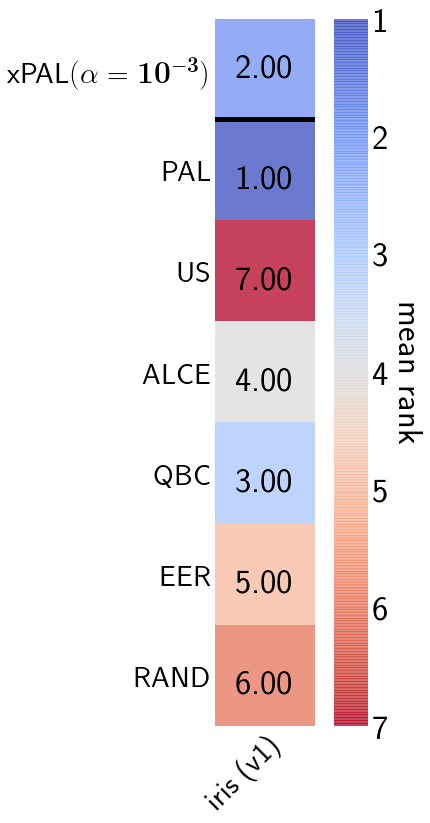

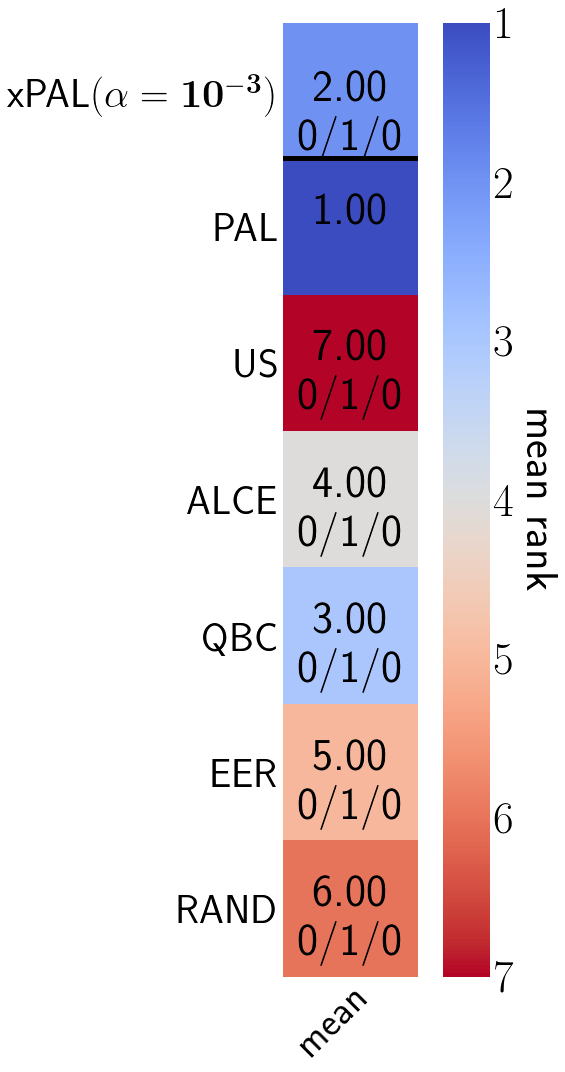

In [7]:
strategy_names = query_strategy_dict.values()
stragety_names_fig = str(list(query_strategy_dict.keys())).replace('[', '').replace(']', '').replace(',', '_').replace('\'','')

#---------------------------------------MEAN RANKS PER DATA SET----------------------------------------------
fontsize = 35
fig, ax = plt.subplots(figsize=((auc_ranks_matrix.shape[1]* 2 + 3), (auc_ranks_matrix.shape[0]) * 2 + 3))
aspect = 20
pad_fraction = 0.5
im = ax.imshow(auc_ranks_matrix, cmap='coolwarm', vmin=1, vmax=n_strategies, alpha=0.75)
divider = make_axes_locatable(ax)
width = axes_size.AxesY(ax, aspect=1./aspect)
pad = axes_size.Fraction(pad_fraction, width)
ax.set_xticks(np.arange(auc_ranks_matrix.shape[1]))
ax.set_yticks(np.arange(auc_ranks_matrix.shape[0]))
ax.set_xticklabels(np.array(data_set_names_openml)[is_available])
ax.set_yticklabels(strategy_names)
ax.xaxis.set_tick_params(labelsize=fontsize-5, color='k')
ax.yaxis.set_tick_params(labelsize=fontsize-5, color='k')
ax.set_ylim(n_strategies-0.5, -0.5)
ax.axhline(0.5, color='k', lw=5)
plt.sca(ax)
plt.grid()
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
best_ids = np.argmin(auc_ranks_matrix, axis=0)

# Loop over data dimensions and create text annotations.
for i in range(auc_ranks_matrix.shape[0]):
    for j in range(auc_ranks_matrix.shape[1]):
        offset = 0.1 if i != 0 else 0
        if best_ids[j] == i:
            text = ax.text(j, i + offset, '{0:.2f}'.format(auc_ranks_matrix[i, j]), ha="center", va="center", color='black', fontsize=fontsize, fontweight='bold')
            if test_results[j, i] < 0:
                sig_str = '$\dagger$' * abs(int(test_results[j, i]))
                text = ax.text(j, i + offset - 0.3, sig_str, ha="center", va="center", color='k', fontweight=0, fontsize=fontsize, fontstyle='oblique')
        else:
            if test_results[j, i] > 0:
                text = ax.text(j, i + offset, '{0:.2f}'.format(auc_ranks_matrix[i, j]), ha="center", va="center", color='k', fontweight=0, fontsize=fontsize, fontstyle='oblique')
                sig_str = '*' * int(test_results[j, i])
                text = ax.text(j, i + offset - 0.3, sig_str, ha="center", va="center", color='k', fontweight=0, fontsize=fontsize, fontstyle='oblique')
            elif test_results[j, i] < 0:
                text = ax.text(j, i + offset, '{0:.2f}'.format(auc_ranks_matrix[i, j]), ha="center", va="center", color='k', fontweight=0, fontsize=fontsize, fontstyle='oblique')
                sig_str = '$\dagger$' * abs(int(test_results[j, i]))
                text = ax.text(j, i + offset - 0.3, sig_str, ha="center", va="center", color='k', fontweight=0, fontsize=fontsize, fontstyle='oblique')
            else:
                text = ax.text(j, i + offset, '{0:.2f}'.format(auc_ranks_matrix[i, j]), ha="center", va="center", color='black', fontsize=fontsize)
        

cax = divider.append_axes("right", size=width, pad=pad)
cbar = ax.figure.colorbar(im, cax=cax)
cbar.ax.set_yticklabels(np.arange(1, n_strategies+1))
cbar.ax.invert_yaxis() 
cbar.ax.tick_params(labelsize=fontsize, color='k')
cbar.ax.set_ylabel('mean rank', rotation=-90, va="bottom", fontsize=fontsize, color='k')
fig.tight_layout()
fig.savefig("../../images/aulc_per_data_set_{}_{}.pdf".format(stragety_names_fig, kernel), bbox_inches='tight')
plt.show()

#---------------------------------------MEAN RANKS OVER ALL DATA SETS------------------------------------------
fontsize=45
auc_ranks_matrix_mean = np.mean(auc_ranks_matrix, axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(15, 15))
aspect = 20
pad_fraction = 0.5
im = ax.imshow(auc_ranks_matrix_mean, cmap='coolwarm', vmin=1, vmax=n_strategies)
divider = make_axes_locatable(ax)
width = axes_size.AxesY(ax, aspect=1./aspect)
pad = axes_size.Fraction(pad_fraction, width)
ax.set_xticks(np.arange(auc_ranks_matrix_mean.shape[1]))
ax.set_yticks(np.arange(auc_ranks_matrix_mean.shape[0]))
ax.set_xticklabels(['mean'], color='k')
ax.set_yticklabels(strategy_names, color='k')
ax.xaxis.set_tick_params(labelsize=fontsize-5, color='k')
ax.yaxis.set_tick_params(labelsize=fontsize-5, color='k')
ax.set_ylim(n_strategies-0.5, -0.5)
ax.axhline(0.5, color='k', lw=5)
plt.sca(ax)
plt.grid()
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
best_ids = np.argmin(auc_ranks_matrix_mean, axis=0)

# Loop over data dimensions and create text annotations.
for i in range(auc_ranks_matrix_mean.shape[0]):
    offset = -0.1 if i != 0 else 0
    if best_ids[0] == i:
        text = ax.text(0, i + offset, '{0:.2f}'.format(auc_ranks_matrix_mean[i, 0]), ha="center", va="center", color='black', fontsize=fontsize, fontweight='bold')
    else:
        text = ax.text(0, i + offset, '{0:.2f}'.format(auc_ranks_matrix_mean[i, 0]), ha="center", va="center", color='k', fontweight=0, fontsize=fontsize, fontstyle='oblique')
        
        wins = np.sum(test_results[:, i] == 3)
        losses = np.sum(test_results[:, i] == -3)
        draws = len(test_results[:, i]) - wins - losses
        result_str = '{}/{}/{}'.format(wins, draws, losses)
        text = ax.text(0, i + offset + 0.35, result_str, ha="center", va="center", color='k', fontweight=0, fontsize=fontsize, fontstyle='oblique')
            
cax = divider.append_axes("right", size=width, pad=pad)
cbar = ax.figure.colorbar(im, cax=cax)
cbar.ax.invert_yaxis() 
cbar.ax.tick_params(labelsize=fontsize, color='k')
cbar.ax.set_ylabel('mean rank', rotation=-90, va="bottom", fontsize=fontsize, color='k')
fig.tight_layout()
fig.savefig("../../images/aulc_mean_{}_{}.pdf".format(stragety_names_fig, kernel), bbox_inches='tight')
plt.show()

## Runtime Evaluation

In [8]:
# data sets
data_sets = pd.read_csv('../../data_set_ids.csv', index_col='id')
data_set_names = data_sets.name.values[sorting]
data_set_names_openml = [data_set_openml[d] for d in data_set_names]
n_instances_sorted = n_instances_list[sorting]

# setup for query strategies
query_strategy_dict = {
                       'xpal-0.001': r'xPAL$(\mathbf{\alpha}=\mathbf{10^{-3}})$',
                       'pal-1': 'PAL',
                       'optimal': 'OPT',
                       'lc': 'US',
                       'alce': 'ALCE',
                       'qbc': 'QBC',
                       'zero-one-loss': 'EER',
                       'random': 'RAND',
                      }
n_strategies = len(query_strategy_dict)

# compute mean times per data set
mean_times = np.zeros((n_strategies, len(data_set_names)))
is_available = np.zeros(len(data_set_names), dtype=bool)
for d_idx, d in enumerate(data_set_names):
    for q_idx, q in enumerate(query_strategy_dict.keys()):
        time_list = []
        csv_name = '{}_{}_{}_{}_{}_{}'.format(d, q, test_ratio, kernel, bandwidth, budget)
        for file in os.listdir(abs_path):
            if csv_name in file:
                is_available[d_idx] = True
                path = os.path.join(abs_path, file)
                df = pd.read_csv(path)
                times = df['time'].values
                time_list.append(np.mean(times[1:]))
            mean_times[q_idx, d_idx] = np.mean(time_list) if len(time_list) else np.nan
mean_times = mean_times[:, is_available]

# create LaTeX table of mean execution times  
strategy_names = list(query_strategy_dict.values())
strategy_names.insert(0, 'number of instances')
data_set_names_openml = np.array([data_set_openml[d] for d in data_set_names])
df = pd.DataFrame(index=data_set_names_openml[is_available], columns=strategy_names)
for d_idx, d in enumerate(data_set_names_openml[is_available]):
    for q_idx, q in enumerate(strategy_names):
        if q == 'number of instances':
            df.loc[d][q] = '{}'.format(n_instances_sorted[d_idx])
        else:
            df.loc[d][q] = '{0:2.4f}'.format(mean_times[q_idx-1, d_idx])        
print(df.to_latex())

\begin{tabular}{llllllllll}
\toprule
{} & number of instances & xPAL\$(\textbackslash mathbf\{\textbackslash alpha\}=\textbackslash mathbf\{10\textasciicircum \{-3\}\})\$ &     PAL &     OPT &      US &    ALCE &     QBC &     EER &    RAND \\
\midrule
iris (v1) &                 150 &                                   0.0032 &  0.0035 &  0.0051 &  0.0004 &  0.0021 &  0.0221 &  0.0037 &  0.0001 \\
\bottomrule
\end{tabular}

